## Read sample COCO img

In [1]:
import cv2
import IPython

In [2]:
# if input image is in range 0..1, please first multiply img by 255
# assume image is ndarray of shape [height, width, channels] where channels can be 1, 3 or 4
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
img = cv2.imread('000000000001.jpg')

## Load same faster rcnn model as in VAS, run prediction on img

In [4]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

import torch

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

model = build_model(cfg).eval()

DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

outputs = model([torch.from_numpy(img).permute(2,0,1)])

tensor shape: torch.Size([3, 480, 640]), size_divisibility: 32, pad_value: 0.0


In [6]:
img.shape, torch.from_numpy(img).permute(2,0,1).shape

((480, 640, 3), torch.Size([3, 480, 640]))

In [7]:
outputs[0]['instances']

Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.8124,  10.1531, 635.7438, 217.2254],
        [  0.0000, 127.5443, 461.2285, 313.6560],
        [257.9050, 154.3555, 294.1206, 234.5074],
        [207.1271, 111.1354, 273.8721, 135.3514]], device='cuda:0',
       grad_fn=<IndexBackward>)), scores: tensor([0.9940, 0.9885, 0.9784, 0.7326], device='cuda:0',
       grad_fn=<IndexBackward>), pred_classes: tensor([ 7,  2, 12,  2], device='cuda:0')])

### Visualise output

In [8]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

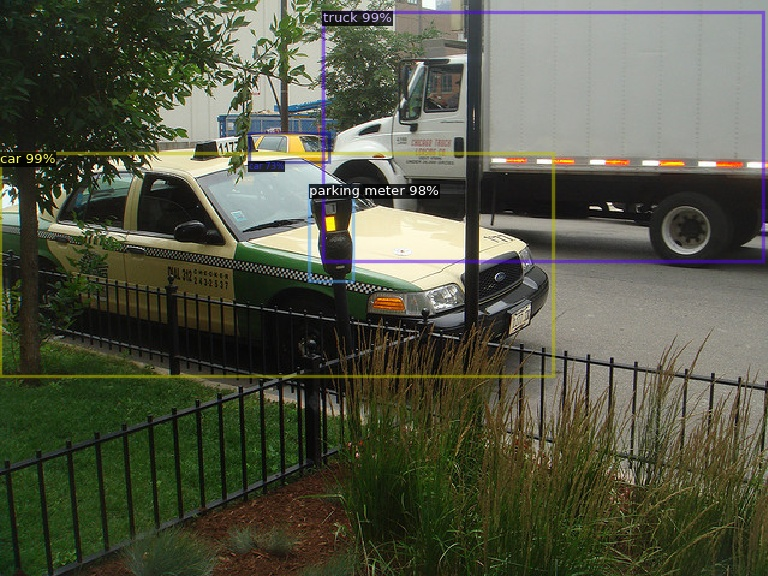

In [9]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
imshow(out.get_image()[:, :, ::-1])

## Captum

In [10]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

## Run on model

In [11]:
input_   = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
baseline = torch.zeros(input_.shape)
baseline.shape

torch.Size([1, 3, 480, 640])

### Need input_/baseline to be tensor, model needs to take in individual tensor

In [24]:
def wrap(input_tensor):
    print(input_tensor.shape)
    return model(input_tensor)

In [25]:
ig = IntegratedGradients(wrap)
attributions, delta = ig.attribute(input_, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

torch.Size([50, 3, 480, 640])


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.88 GiB already allocated; 0 bytes free; 2.89 GiB reserved in total by PyTorch)

In [27]:
gs = GradientShap(model)

# We define a distribution of baselines and draw `n_samples` from that
# distribution in order to estimate the expectations of gradients across all baselines
baseline_dist = torch.randn(5, 3, 480, 640) * 0.001
attributions, delta = gs.attribute(input_, stdevs=0.09, n_samples=4, baselines=baseline_dist,
                                   target=0, return_convergence_delta=True)
print('GradientShap Attributions:', attributions)
print('Convergence Delta:', delta)
print('Average delta per example:', torch.mean(delta.reshape(input.shape[0], -1), dim=1))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.88 GiB already allocated; 0 bytes free; 2.89 GiB reserved in total by PyTorch)

In [28]:
dl = DeepLift(model)
attributions, delta = dl.attribute(input_, baseline, target=0, return_convergence_delta=True)
print('DeepLift Attributions:', attributions)
print('Convergence Delta:', delta)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.88 GiB already allocated; 0 bytes free; 2.89 GiB reserved in total by PyTorch)

In [33]:
baseline_dist = torch.randn(5, 3, 480, 640) * 0.001

dl = DeepLiftShap(model)
attributions, delta = dl.attribute(input_, baseline_dist, target=0, return_convergence_delta=True)
print('DeepLiftSHAP Attributions:', attributions)
print('Convergence Delta:', delta)

RuntimeError: only Tensors of floating point dtype can require gradients

In [34]:
input_

tensor([[[[ 17,  16,  18,  ..., 161, 163, 163],
          [ 23,  18,  17,  ..., 161, 161, 163],
          [ 27,  21,  17,  ..., 161, 161, 161],
          ...,
          [ 24,   9,  13,  ...,  14,  27,  15],
          [ 44,  31,  28,  ...,  18,  27,  22],
          [ 61,  50,  44,  ...,  19,  22,  25]],

         [[ 23,  21,  25,  ..., 164, 163, 163],
          [ 27,  25,  24,  ..., 164, 163, 163],
          [ 31,  26,  25,  ..., 165, 164, 163],
          ...,
          [ 50,  24,  25,  ...,  39,  53,  41],
          [ 58,  42,  38,  ...,  45,  54,  49],
          [ 47,  47,  49,  ...,  48,  51,  54]],

         [[ 18,  19,  22,  ..., 155, 157, 157],
          [ 21,  18,  19,  ..., 155, 157, 157],
          [ 20,  17,  15,  ..., 154, 155, 157],
          ...,
          [ 14,  26,  37,  ...,  29,  40,  28],
          [ 22,  22,  32,  ...,  36,  44,  39],
          [ 53,  32,  28,  ...,  39,  42,  45]]]], dtype=torch.uint8)

In [35]:
baseline_dist[]

tensor([[[[-1.0526e-03, -1.2644e-03,  1.3083e-03,  ..., -2.2818e-03,
           -2.3576e-04,  1.2221e-03],
          [ 1.4297e-03,  2.4617e-04, -7.4143e-04,  ...,  5.0483e-04,
            8.5284e-04,  8.7669e-04],
          [ 2.4143e-04,  4.1163e-04, -1.0570e-03,  ..., -3.8045e-05,
           -9.9686e-04,  7.8712e-04],
          ...,
          [-2.1854e-03,  7.6675e-04, -6.6449e-04,  ..., -1.9214e-03,
            1.9576e-03,  1.9591e-04],
          [ 1.3035e-03,  2.4883e-04,  3.8911e-04,  ...,  1.2624e-03,
           -1.8048e-03,  8.3664e-04],
          [ 8.3628e-05,  1.0324e-04, -4.1623e-04,  ..., -2.6539e-04,
           -1.4971e-04, -4.9887e-04]],

         [[-1.6251e-03,  3.5411e-04, -1.1846e-03,  ...,  2.1951e-03,
           -1.4757e-04,  1.7264e-04],
          [ 1.2733e-03,  5.3882e-04, -2.1314e-03,  ..., -5.7396e-05,
            2.9820e-04, -1.5901e-03],
          [-2.2434e-04, -1.1727e-03, -3.3088e-04,  ...,  1.5419e-03,
           -5.7105e-04,  6.3628e-04],
          ...,
     